<a href="https://colab.research.google.com/github/ssundar6087/autoencoders/blob/main/vae_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
IMG_SIZE = 28
N_CHANNELS = 1

In [4]:
# Load the dataset
transform = transforms.Compose(
    [
    transforms.ToTensor(),
     ])

train_dataset = datasets.FashionMNIST(root=".", 
                                      download=True, 
                                      train=True,
                                      transform=transform,
                                      )

test_dataset = datasets.FashionMNIST(root=".", 
                                      download=True, 
                                      train=False,
                                      transform=transform,
                                      )

In [5]:
# Create dataloaders
batch_size=128
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


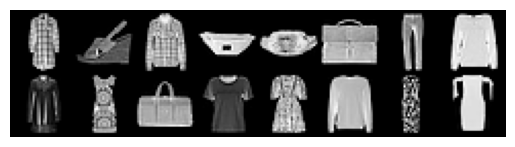

In [6]:
# Plot some images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
#print(dataiter)
images, labels = next(dataiter)

# show image
imshow(torchvision.utils.make_grid(images[:16]))

In [7]:
# Encoder
class Encoder(nn.Module):
  def __init__(self, 
               in_dim, 
               in_channels, 
               encoding_dim,
               device,
               ):
    super(Encoder, self).__init__()

    # Define the layers of the encoder
    self.encoding_dim = encoding_dim
    self.fc_dim = 512
    self.in_channels = in_channels
    self.in_dim = in_dim
    self.device = device
    self.flatten_dim = self.in_channels * self.in_dim**2
    self.fc1 = nn.Linear(self.flatten_dim, 
                         self.fc_dim,
                         )
    self.relu = nn.ReLU()
    
    self.mean = nn.Linear(self.fc_dim, self.encoding_dim)
    self.var = nn.Linear(self.fc_dim, self.encoding_dim)

    # How the VAE Samples data
    self.N = torch.distributions.Normal(0, 1)
    self.N.loc = self.N.loc.cuda() 
    self.N.scale = self.N.scale.cuda()
    self.kl_loss = 0
    self.mu = 0
    self.sigma = 0

    

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    self.mu =  self.mean(x)
    self.sigma = torch.exp(self.var(x))
    z = self.mu + self.sigma*self.N.sample(self.mu.shape)  

    return z
  
  def compute_kl_loss(self):
    self.kl_loss = (self.sigma**2 + self.mu**2 - torch.log(self.sigma) - 1/2).sum()
    return self.kl_loss


In [8]:
vae_encoder_test = Encoder(in_dim=IMG_SIZE,
                           in_channels=N_CHANNELS,
                           encoding_dim = 128,
                           device=device,)


In [9]:
random_tns = torch.randn(size=(33,N_CHANNELS,IMG_SIZE,IMG_SIZE))
random_tns = random_tns.to(device)
vae_encoder_test = vae_encoder_test.to(device)

In [10]:
out = vae_encoder_test(random_tns)
out.shape

torch.Size([33, 128])

In [11]:
# Decoder
class Decoder(nn.Module):
  def __init__(self, 
               out_dim, 
               out_channels, 
               encoding_dim,
               device,
               ):
    super(Decoder, self).__init__()
    self.encoding_dim = encoding_dim
    self.fc_dim = 512
    self.out_channels = out_channels
    self.out_dim = out_dim
    self.device = device

    self.reshape_dim = self.out_channels * self.out_dim**2
    self.fc1 = nn.Linear(self.encoding_dim,  
                         self.fc_dim,
                         )
    self.fc2 = nn.Linear(self.fc_dim, self.reshape_dim)
    self.relu = nn.ReLU()

  def forward(self, z):
    z = self.relu(self.fc1(z))
    y = torch.sigmoid(self.fc2(z))
    return y.reshape((-1, 
                      self.out_channels,
                      self.out_dim,
                      self.out_dim,
                      )) 

In [12]:
vae_decoder_test = Decoder(out_dim=IMG_SIZE,
                           out_channels=N_CHANNELS,
                           encoding_dim=128,
                           device=device,
                           )

In [13]:
vae_decoder_test = vae_decoder_test.to(device)
final_out = vae_decoder_test(out)
final_out.shape

torch.Size([33, 1, 28, 28])

In [14]:
# Define model
class VAE(nn.Module):
  def __init__(self, 
               in_dim, 
               n_channels, 
               encoding_dim,
               device,
               ):
    super(VAE, self).__init__()

    # Parameters
    self.dim = in_dim
    self.channels = n_channels
    self.encoding_dim = encoding_dim
    self.device = device

    # Encoder
    self.encoder = Encoder(self.dim,
                           self.channels,
                           self.encoding_dim,
                           self.device,
                           )
    # Decoder
    self.decoder = Decoder(self.dim,
                           self.channels,
                           self.encoding_dim,
                           self.device,
                           )
  
  def forward(self, x):
    # Pass through the encoder
    z = self.encoder(x)

    # Reconstruct using decoder
    y = self.decoder(z)
    return y
  
  def compute_kl_loss(self):
    return self.encoder.compute_kl_loss()

In [15]:
vae_test = VAE(in_dim=IMG_SIZE,
               n_channels=N_CHANNELS,
               encoding_dim=128,
               device=device,
               )
vae_test = vae_test.to(device)

In [16]:
output = vae_test(random_tns)
output.shape

torch.Size([33, 1, 28, 28])

In [17]:
IN_DIM = IMG_SIZE
ENCODING_DIM = 2 
vae = VAE(IN_DIM, N_CHANNELS, ENCODING_DIM, device)
vae = vae.to(device)

In [18]:
def reconstruction_loss(output, target, reduce="mean"):
  if reduce == "mean":
    return ((output - target)**2).mean()
  else:
    return ((output - target)**2).sum()

In [19]:
# Optimizer and Loss function
criterion = reconstruction_loss # Loss Function
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001) # Optimizer
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) 
kl_weight = 1 #1e-4 #0.00015

In [20]:
def visualize_samples(model, test_loader, num_samples):
  # Visualize reconstructions
  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = next(dataiter)
  model.eval()
  # get reconstruction
  with torch.no_grad():
    output = model(images.to(device))

  images = images[:num_samples].permute(0, 2, 3, 1).numpy()
  output = output.detach().cpu().permute(0, 2, 3, 1).numpy()
  output = output[:num_samples]


  # plot images and their reconstructions
  fig, axes = plt.subplots(nrows=2, 
                          ncols=num_samples, 
                          sharex=True, 
                          sharey=True, figsize=(25,4))

  # input images on top row, reconstructions on bottom
  titles = ['original', 'reconstruction']
  for images, row, title in zip([images, output], axes, titles):
      for img, ax in zip(images, row):
          ax.imshow(img)
          ax.get_xaxis().set_visible(False)
          ax.set_ylabel(title)
          ax.set_yticks([])
          ax.set_yticklabels([])
  plt.show()
  plt.pause(2)
  plt.close()

In [21]:
def train_step(model, train_loader, optimizer, criterion, kl_weight):
  model.train()
  epoch_loss = []
  total, correct = 0, 0

  for i, batch in tqdm(enumerate(train_loader), 
                       total=len(train_loader),
                       leave=False,
                       ):
    images, labels = batch
    images = images.to(device)

    optimizer.zero_grad() # Erase history - clean slate

    reconstruction = model(images) 
    loss = criterion(reconstruction, 
                     images, "sum") + kl_weight * model.compute_kl_loss()
    epoch_loss.append(loss.item())

    loss.backward() # backward pass
    optimizer.step() # Update the weights using gradients
  
  return np.mean(epoch_loss)

In [22]:
def valid_step(model, val_loader, criterion, kl_weight):
  model.eval()
  epoch_loss = []
  total, correct = 0, 0

  with torch.no_grad():
    for i, batch in tqdm(enumerate(val_loader), 
                        total=len(val_loader),
                        leave=False,
                        ):
      images, labels = batch
      images = images.to(device)

      reconstruction = model(images) 
      loss = criterion(reconstruction, 
                       images, "sum") + kl_weight * model.compute_kl_loss()
      epoch_loss.append(loss.item())
  
  return np.mean(epoch_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

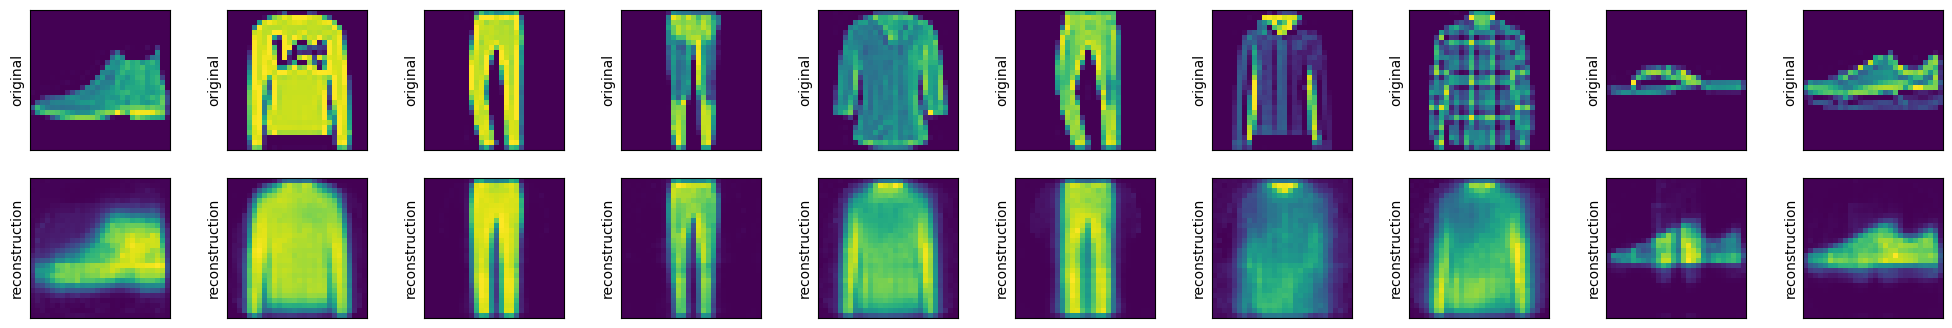

[1] train loss: 5073.898121522688  val loss: 4172.572010668018


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

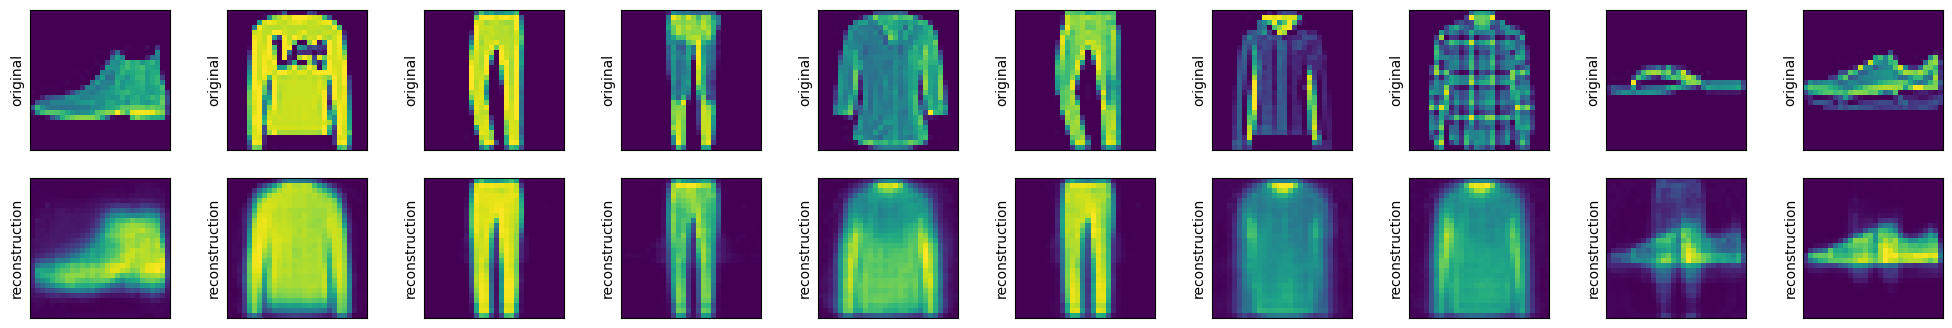

[2] train loss: 4138.075121914146  val loss: 4029.99655189997


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

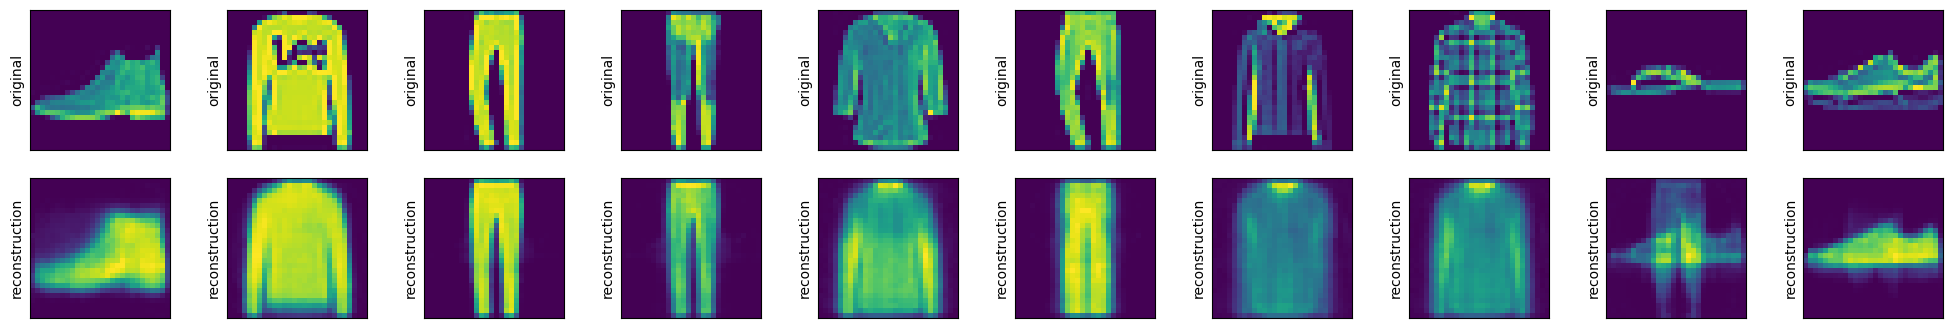

[3] train loss: 4019.897385456923  val loss: 3916.1936552796183


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

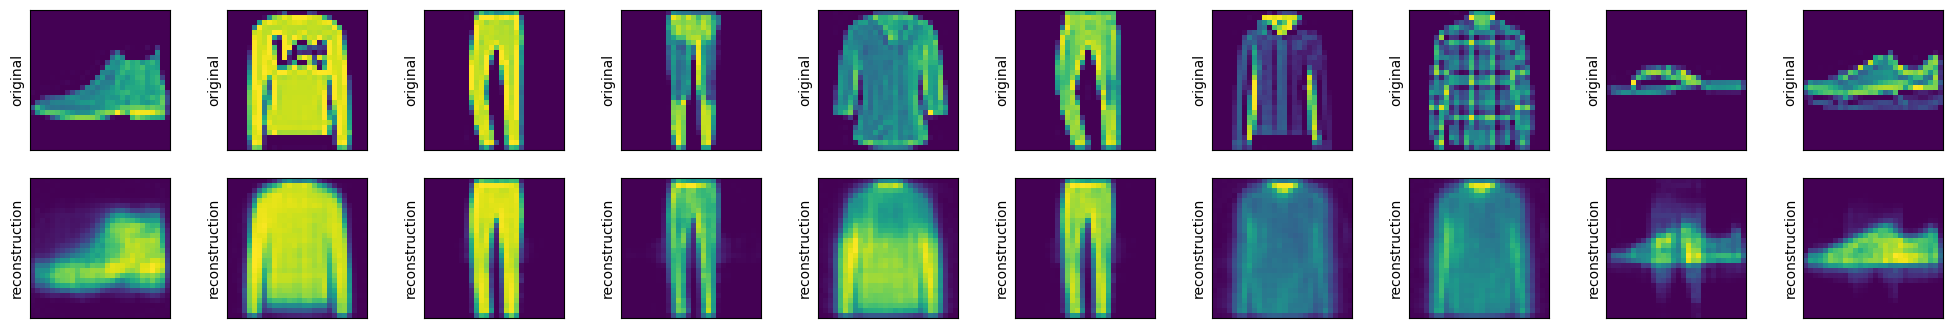

[4] train loss: 3948.0527208405515  val loss: 3891.5292219330995


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

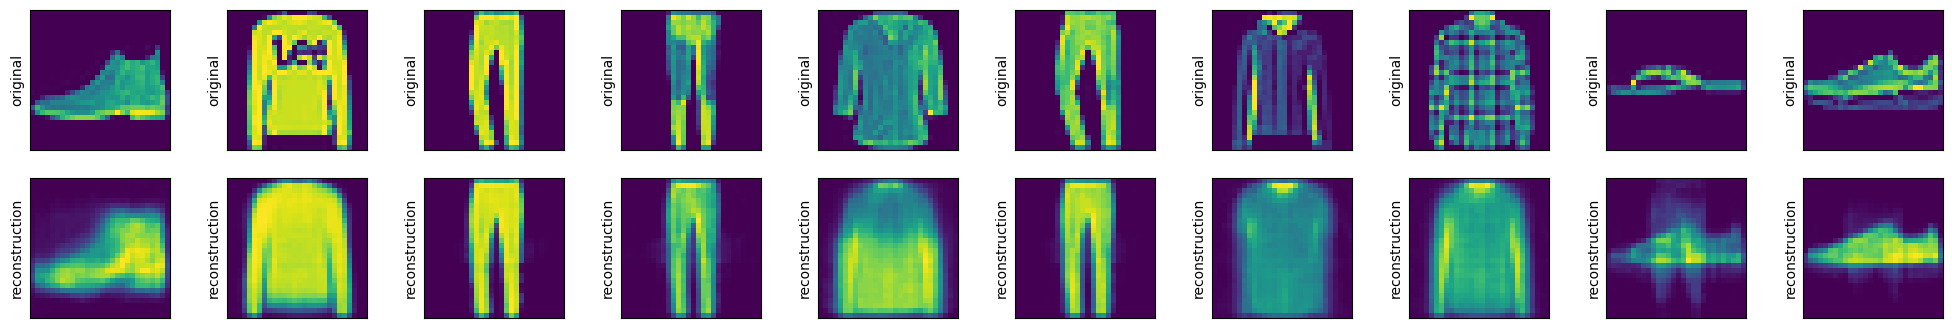

[5] train loss: 3901.7844425681305  val loss: 3841.051081017603


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

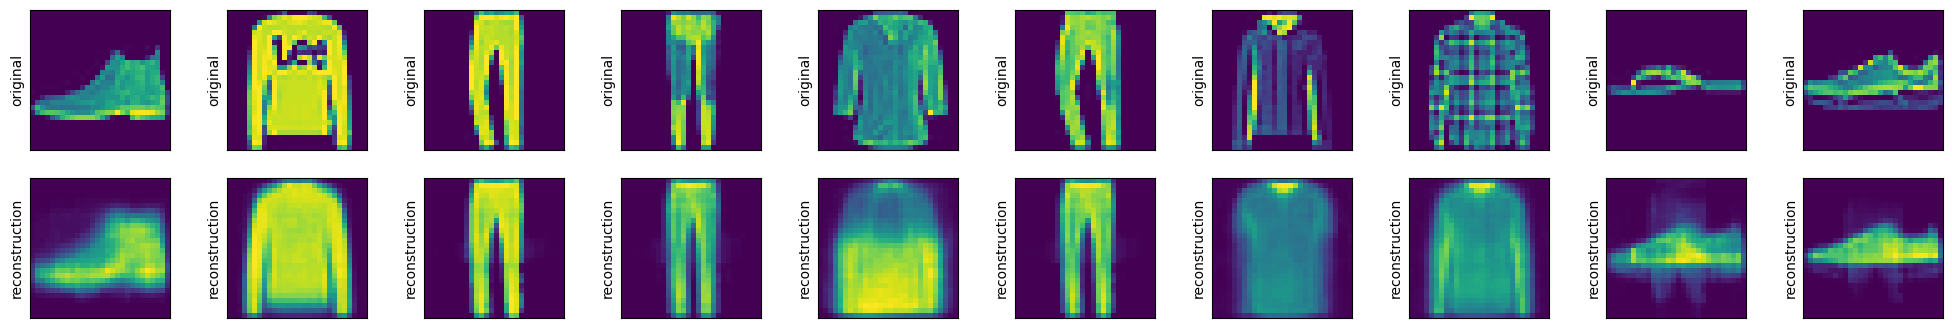

[6] train loss: 3859.9477632762528  val loss: 3801.2464599609375


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

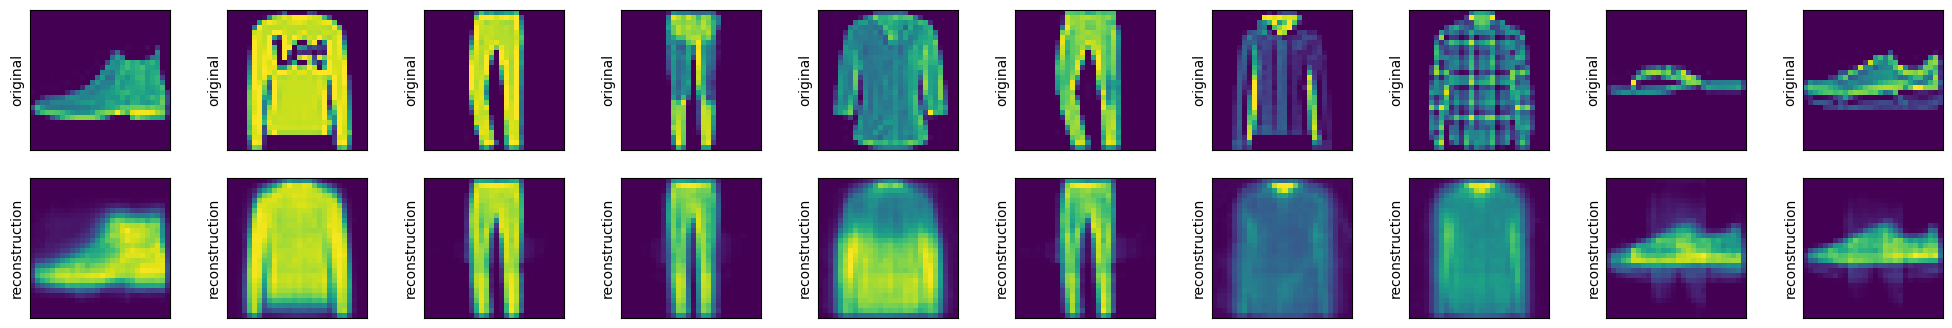

[7] train loss: 3833.738859066831  val loss: 3799.2457638511173


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

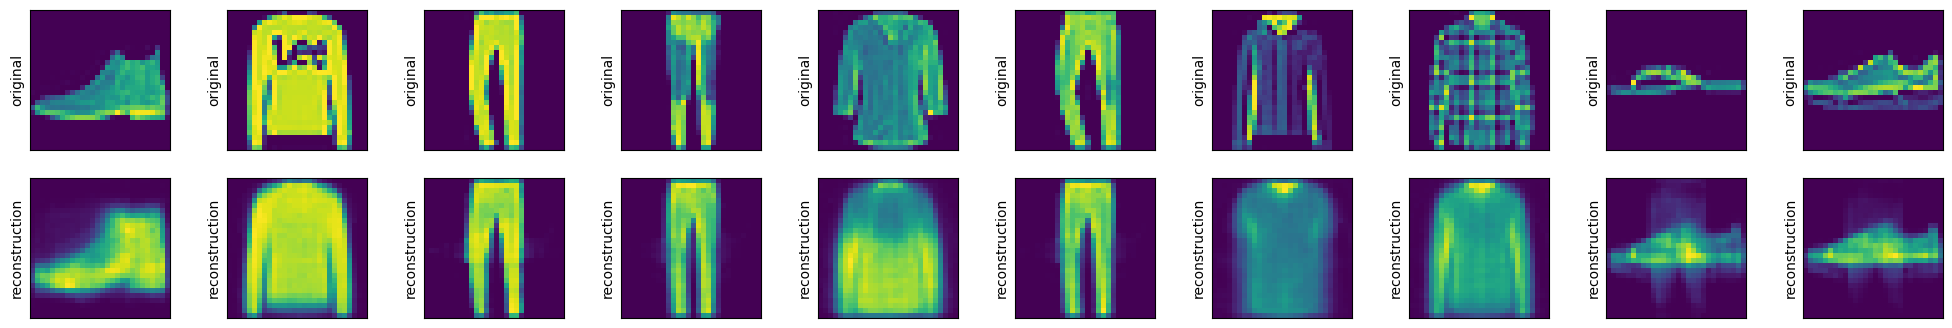

[8] train loss: 3809.009946257829  val loss: 3750.1165539705303


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

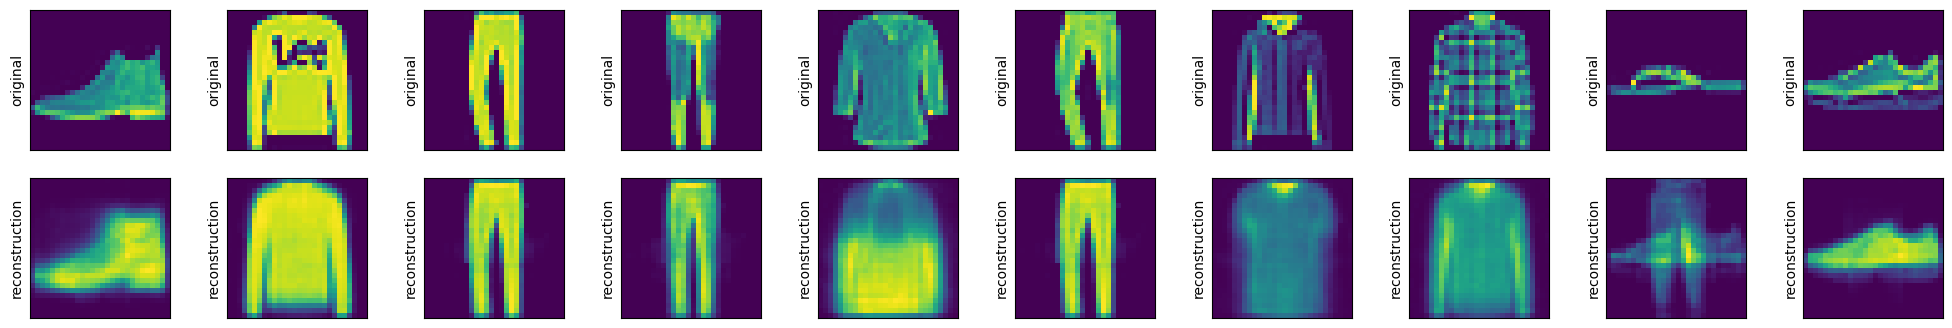

[9] train loss: 3785.5238409306703  val loss: 3729.1219018863726


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

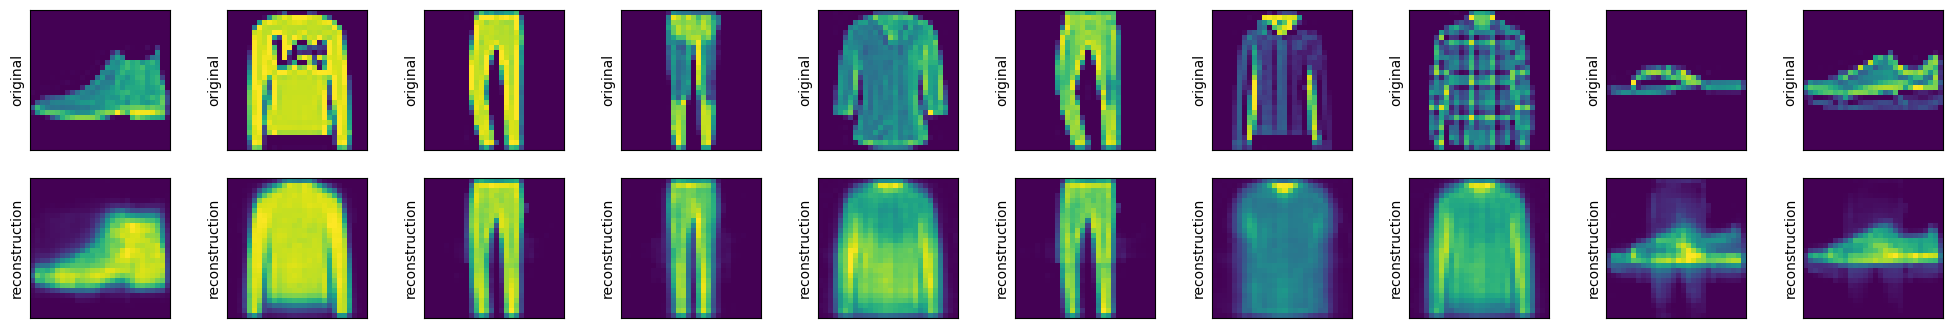

[10] train loss: 3767.3885906683104  val loss: 3708.2685044687005


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

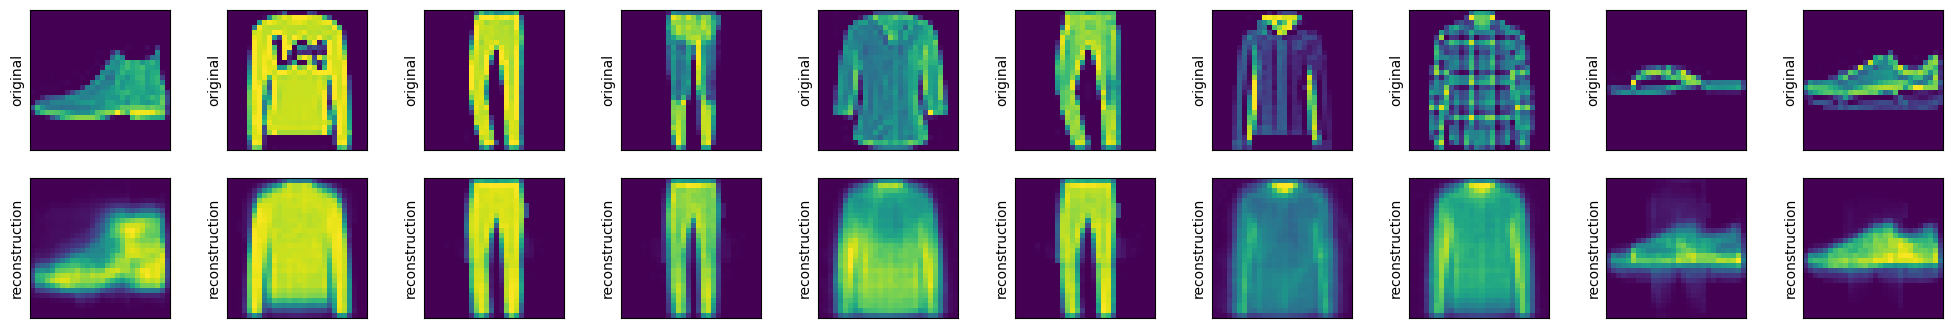

[11] train loss: 3751.7193179262727  val loss: 3720.3802165743673


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

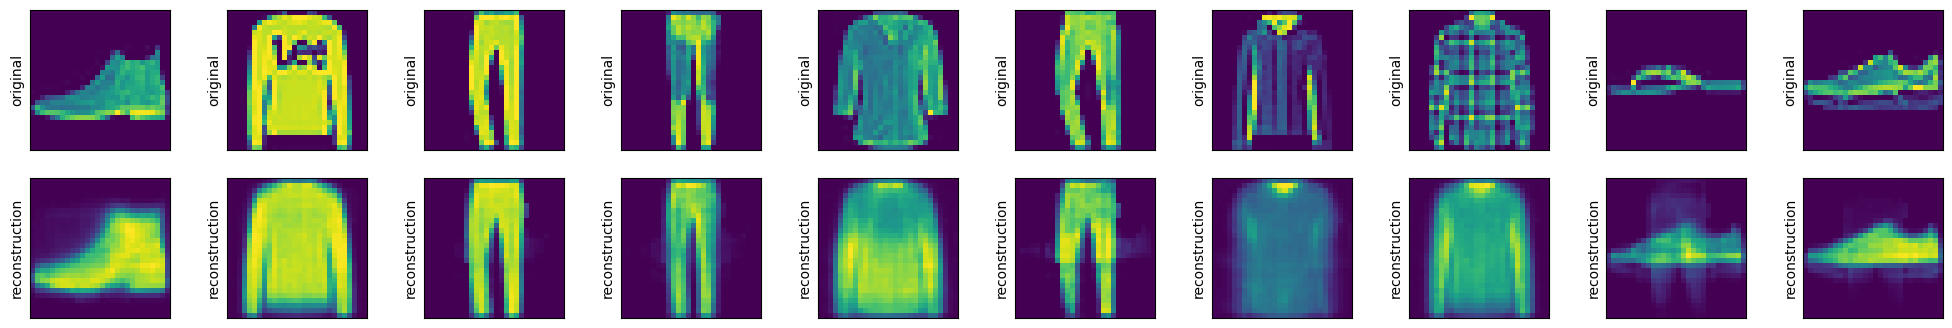

[12] train loss: 3739.1747443030386  val loss: 3753.3622985067245


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

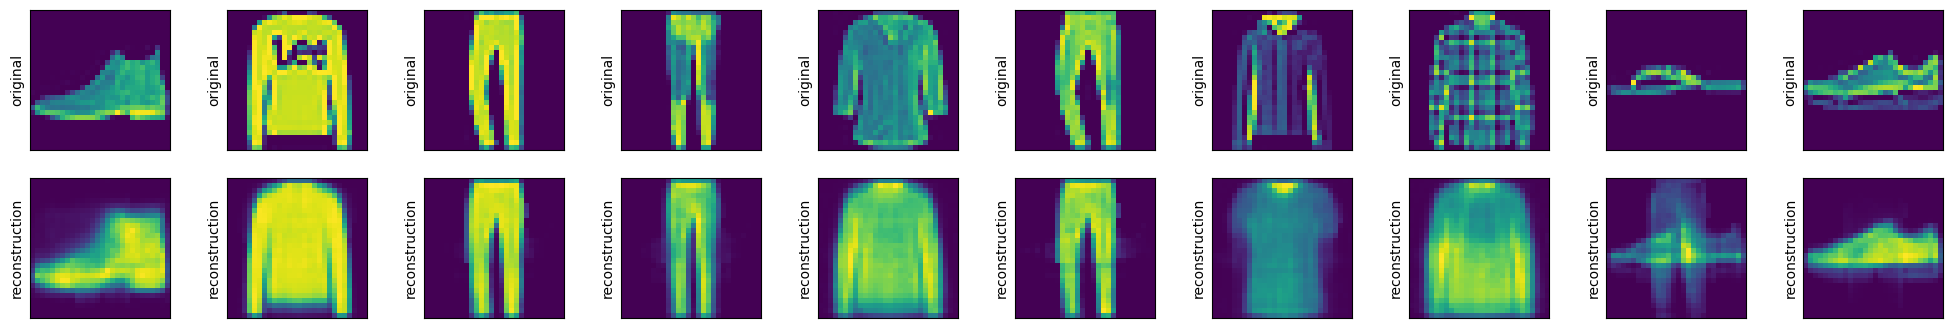

[13] train loss: 3730.537063566098  val loss: 3692.388225313983


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

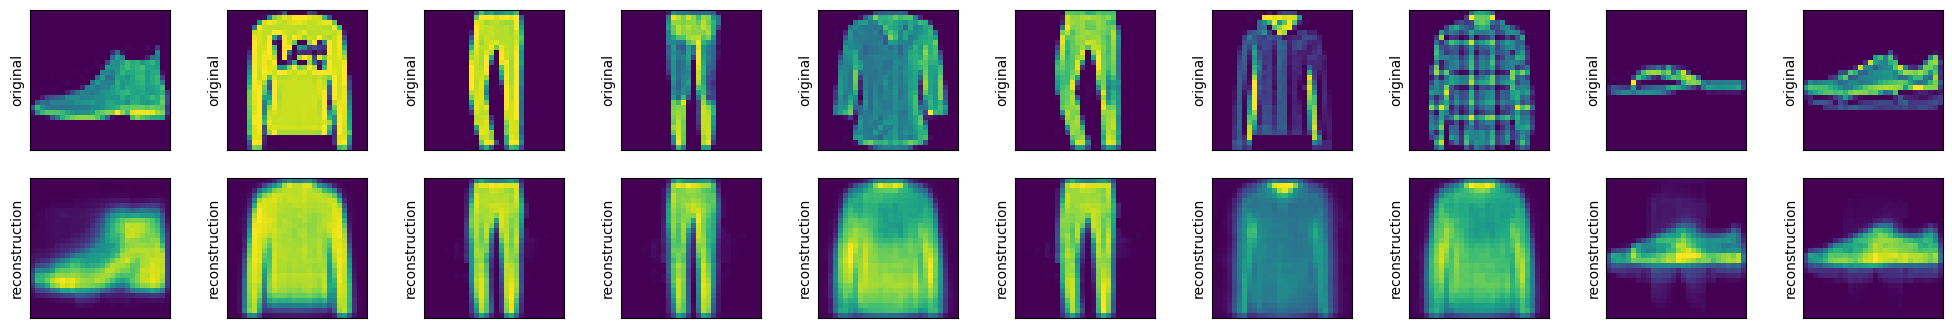

[14] train loss: 3716.1899403651387  val loss: 3698.0994733979433


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

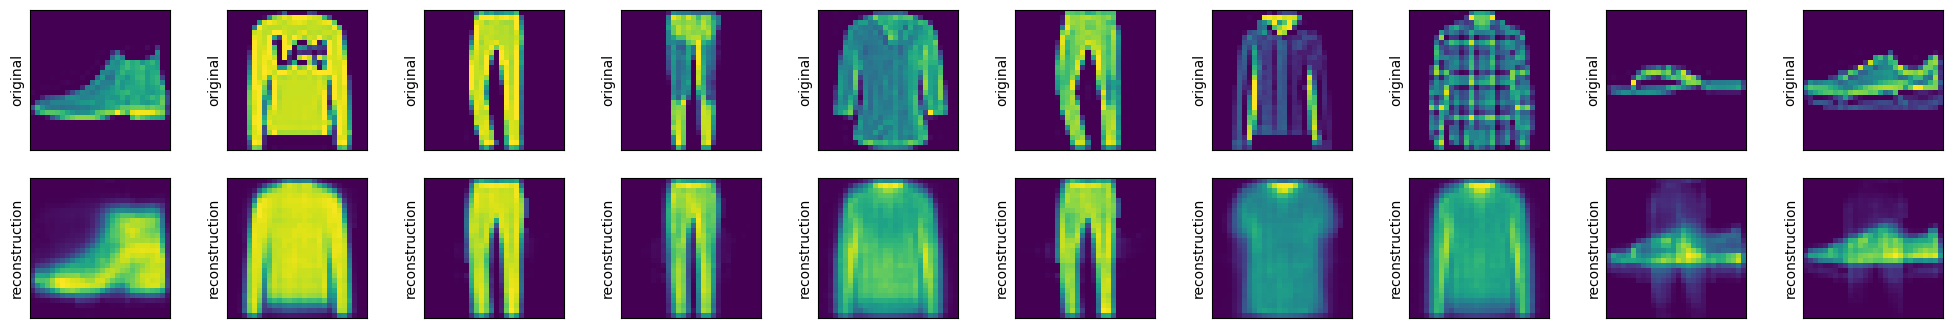

[15] train loss: 3709.1218168018722  val loss: 3691.413564947587


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

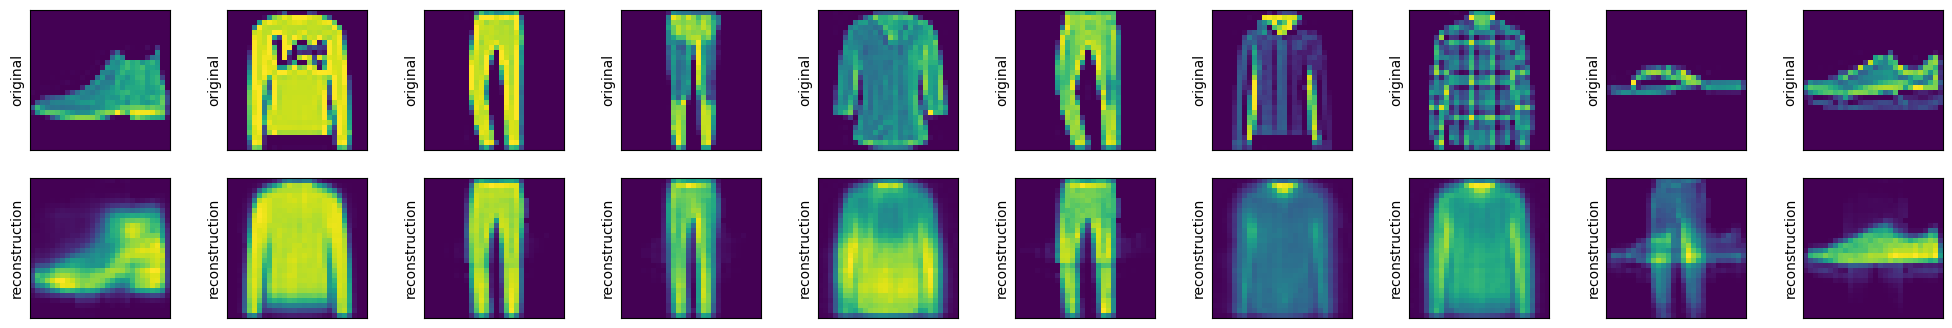

[16] train loss: 3698.0962419001535  val loss: 3672.9133687079707


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

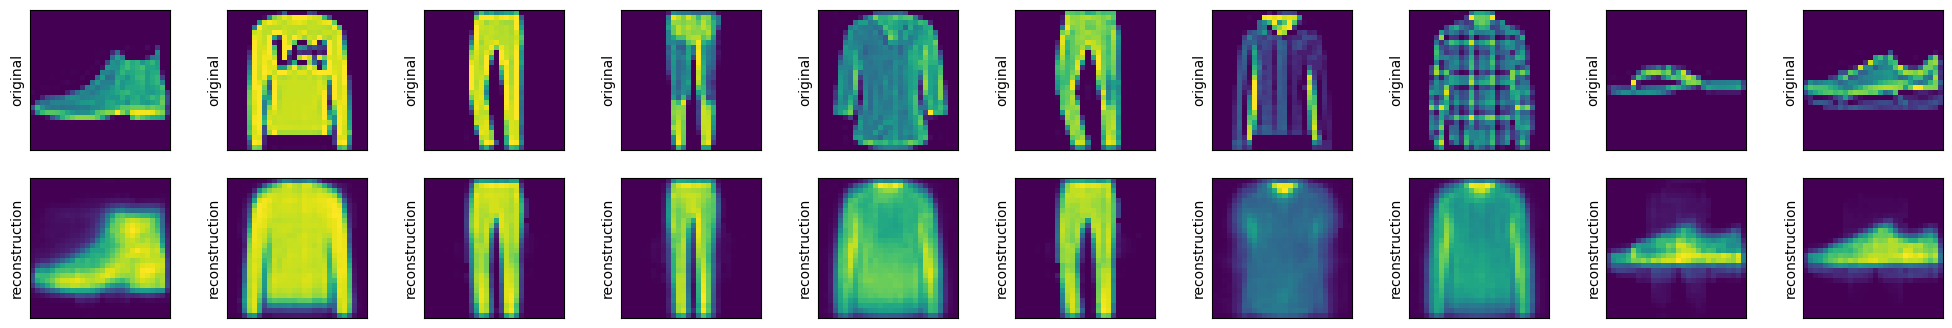

[17] train loss: 3690.5296597023253  val loss: 3663.7441019951543


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

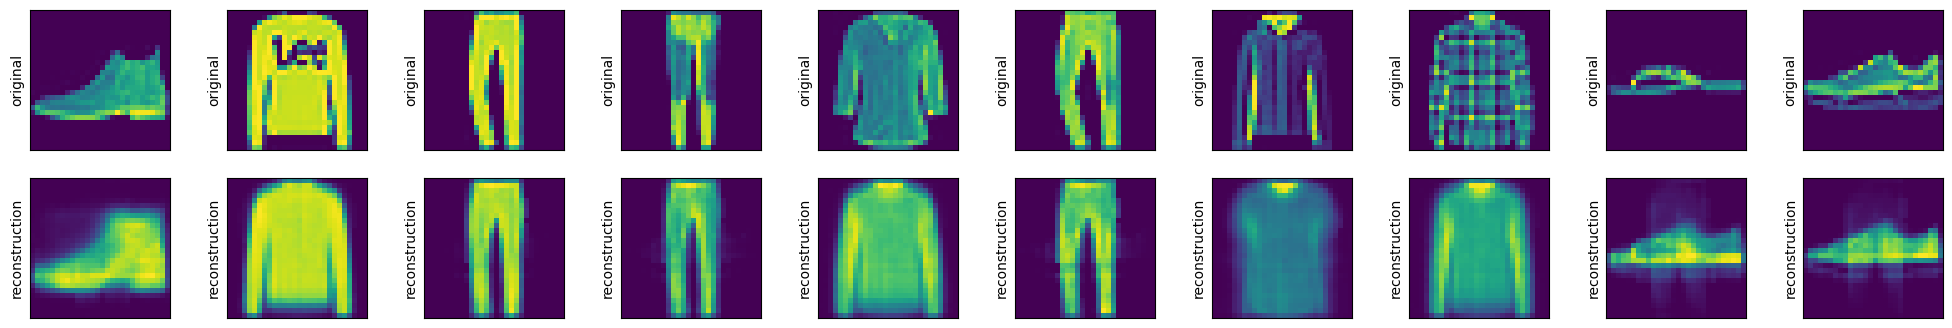

[18] train loss: 3682.7348955557036  val loss: 3661.8984962173654


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

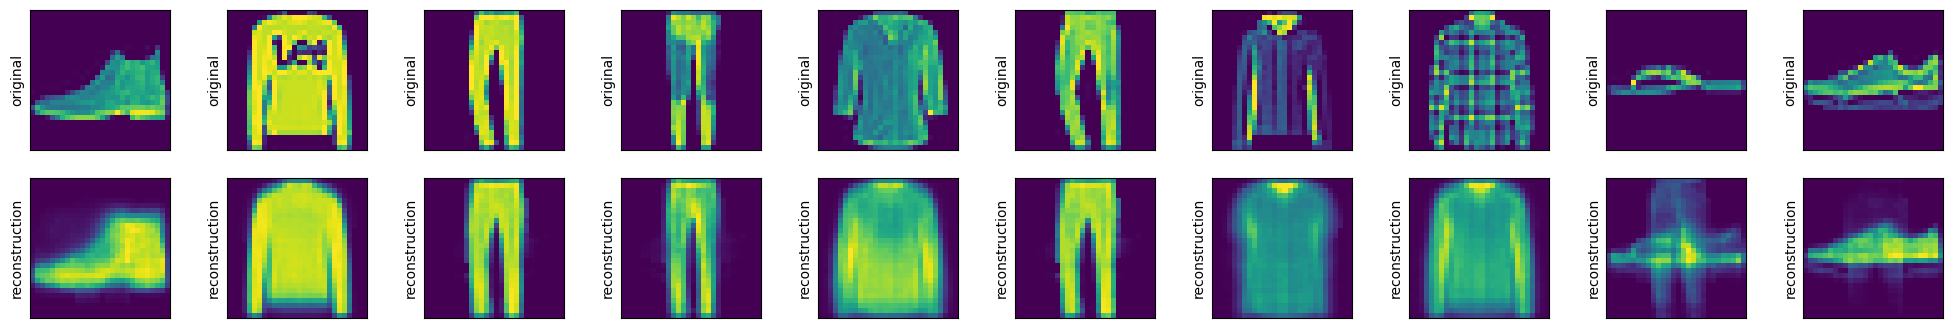

[19] train loss: 3674.170445554038  val loss: 3662.600540354282


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

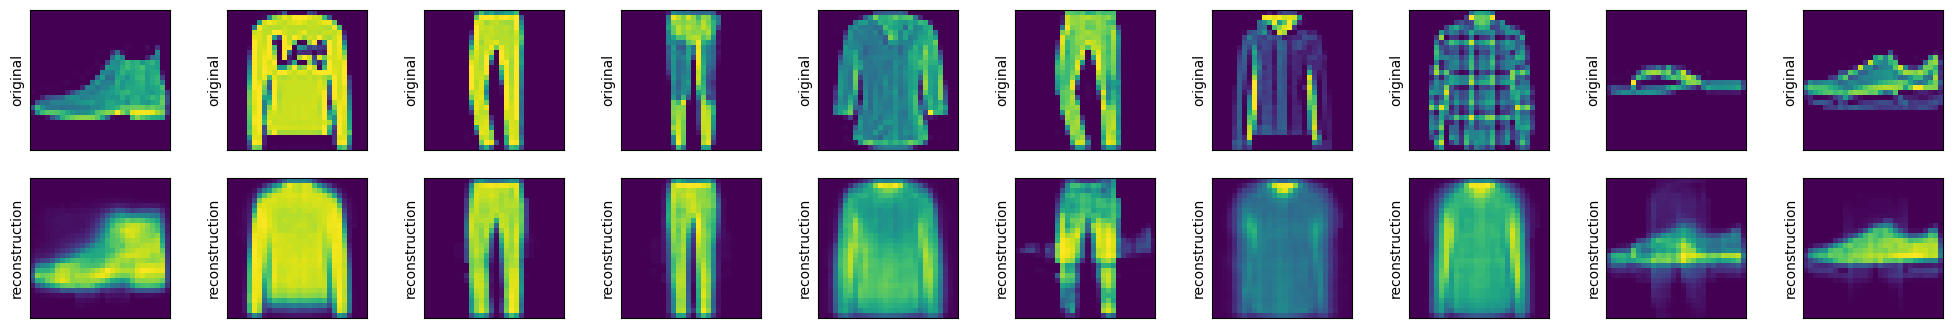

[20] train loss: 3665.217319512926  val loss: 3652.9961555577534


In [23]:
# training loop
EPOCHS = 20
losses = {"train_loss": [], "val_loss": []}
epochs = []
for epoch in tqdm(range(EPOCHS), total=EPOCHS):
  train_loss = train_step(vae, 
                          trainloader, 
                          optimizer, 
                          criterion,
                          kl_weight,
                          )
  
  val_loss = valid_step(vae, 
                        testloader, 
                        criterion,
                        1.0,
                        )
  
  visualize_samples(vae, testloader, 10)
  scheduler.step()
  losses["train_loss"].append(train_loss)
  losses["val_loss"].append(val_loss)
  epochs.append(epoch)

  print(f'[{epoch + 1}] train loss: {train_loss}  val loss: {val_loss}')

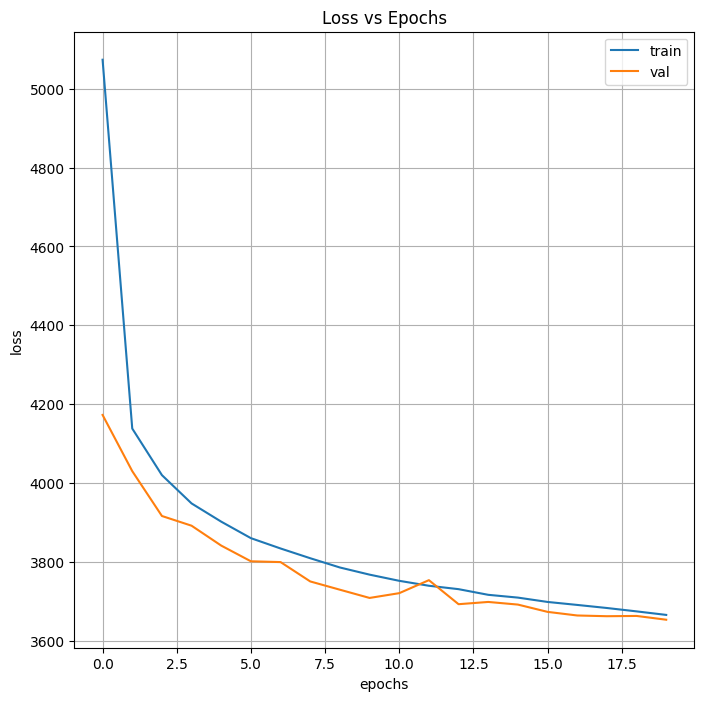

In [24]:
# Plot loss
plt.figure(figsize=(8,8))
plt.plot(epochs, losses["train_loss"], label="train")
plt.plot(epochs, losses["val_loss"], label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.title("Loss vs Epochs");

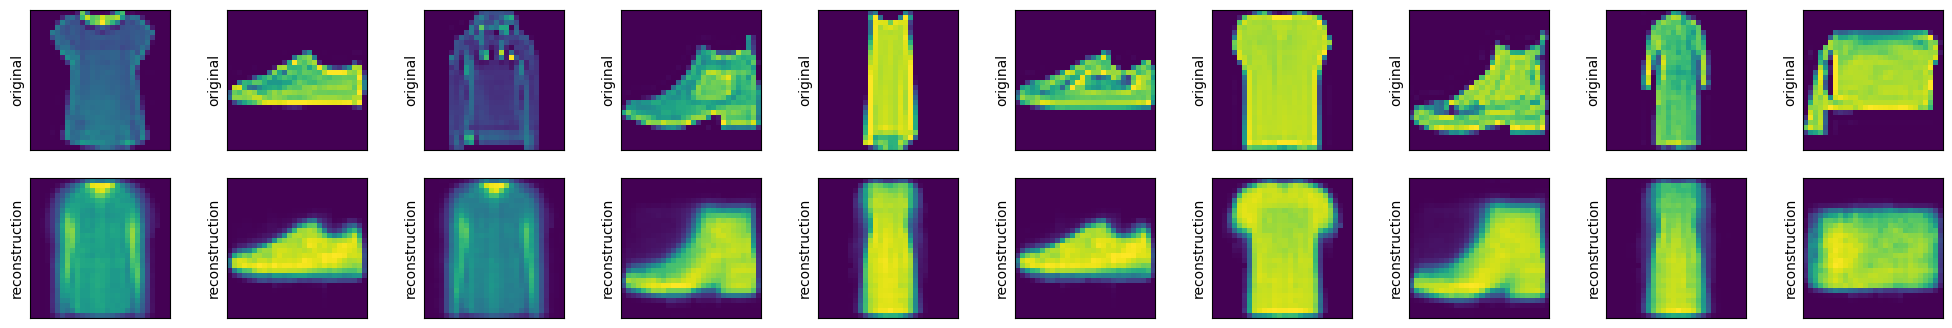

In [25]:
# Visualize reconstructions
# obtain one batch of test images
dataiter = iter(testloader)
for _ in range(10):
  images, labels = next(dataiter)

# get reconstruction
with torch.no_grad():
  output = vae(images.to(device))

images = images[:10].permute(0, 2, 3, 1).numpy()
output = output.detach().cpu().permute(0, 2, 3, 1).numpy()
output = output[:10]


# plot images and their reconstructions
fig, axes = plt.subplots(nrows=2, 
                         ncols=10, 
                         sharex=True, 
                         sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
titles = ['original', 'reconstruction']
for images, row, title in zip([images, output], axes, titles):
    for img, ax in zip(images, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.set_ylabel(title)
        ax.set_yticks([])
        ax.set_yticklabels([])
        